## Libraries

In [1]:
%pip install pinecone-client

Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import seaborn as sns;
import os;
import time;
import itertools
from pinecone import Pinecone, ServerlessSpec, PodSpec;
from collections import Counter


# ***Introduction to Indexes***

These notes will have a simple step to get the Pinecone index up and running

## Connect to the Pinecone DB

We get the API key, then create a spec with a specific dimension (for serverless and server configureations)

In [4]:
use_serverless = False

As I am poor, I will be using Starter index. The configurations for the the starter index is as follows:

| Properties | Value |
| ---------- | ------ |
| Records | 100,000 |
| namespace | 100 |
| Clouds server | GCP |
| Region  | us-central-1 (Iowa) |

- Starter indexes do not support 
  - Replicas
    - duplicating the resources and data in an index
  - Collections 
    - helpful for archiving inactive indexes, and experimenting with different index configurations
  - Deleting records by Metadata
  - Selective Metadata indexing
  - Configuring indexes
  - Describing indexes with Metadata filtering
  - Metrics.

- We can have PodSpecs configured. Pods are the smallest deployable units of computing that you can create and manage in Kubernetes. With pod-based indexes, you choose one or more pre-configured units of hardware (pods). Depending on the pod type, pod size, and number of pods used, you get different amounts of storage and higher or lower latency and throughput.

- We can also use different distance metrics: 
  - euclidean: $d(\mathbf{a}, \mathbf{b}) = \sqrt{\sum_{i=1}^{n}(a_i - b_i)^2}$
  - Cosine: $d(\mathbf{a}, \mathbf{b}) = 1 - \frac{\mathbf{a} \cdot \mathbf{b}}{\|\mathbf{a}\|_2 \|\mathbf{b}\|_2}$
  - dot-product: $d(\mathbf{a}, \mathbf{b}) = \mathbf{a} \cdot \mathbf{b}$


In [5]:

# initialize connection to pinecone 
api_key = os.environ.get('PINECONE_API') 
environment = os.environ.get('PINECONE_ENVIRONMENT')

# configure client
pc = Pinecone(api_key = api_key)

#we setup our index specification
if use_serverless:
    spec = ServerlessSpec(cloud='aws', region='us-west-2')
else:
    spec = PodSpec(environment='gcp-starter')

Creating the Pinecone Index based on the above specifications. We will also ensure that this is the updated index by deleting previous indexes with the same name

In [6]:
index_name = 'hello-pinecone'

def create_index(index_name):
    # ensure no duplicates
    if index_name in pc.list_indexes().names():
        pc.delete_index(index_name)

    dimensions = 3
    pc.create_index(
        name = index_name, 
        dimension = dimensions, # vector dim
        metric = 'cosine', # common similarity
        spec = spec
    )

    # wait for index to be ready before connecting
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

create_index(index_name)

In [7]:
index = pc.Index(index_name)

## Basic operations

We have the index ready. Now we will create some simple vectors to upload and delete from the db

In [7]:
df = pd.DataFrame(
    data={
        "id": ["A", "B"],
        "vector": [[1., 1., 1.], [1., 2., 3.]]
    })
df

,id,vector
0,A,"[1.0, 1.0, 1.0]"
1,B,"[1.0, 2.0, 3.0]"


In [8]:
index.upsert(vectors=zip(df.id, df.vector))  # insert vectors

{'upserted_count': 2}

We can not **Delete** the indices too and close the connection (in this case, the Pinecone client will handle the connection management for you automatically.).

In [9]:
pc.delete_index(index_name)

# ***Interacting with Pinecone indexes***

We will create the same index and then upsert a vector with few values.

In [10]:
create_index(index_name)
index = pc.Index(index_name)

In [11]:
df = pd.DataFrame()
df["id"] = ["A", "B", "C", "D", "E"]
df["vector"] = [[1., 1.,1.], [2., 2.,2.], [3., 3.,3.], [4., 4.,4.], [5., 5.,5.]]
df

,id,vector
0,A,"[1.0, 1.0, 1.0]"
1,B,"[2.0, 2.0, 2.0]"
2,C,"[3.0, 3.0, 3.0]"
3,D,"[4.0, 4.0, 4.0]"
4,E,"[5.0, 5.0, 5.0]"


In [12]:
index.upsert(vectors=zip(df.id, df.vector))

{'upserted_count': 5}

### Fetching vectors

In [13]:
fetch_results = index.fetch(ids  = ["A", "B","C"])
fetch_results

{'namespace': '',
 'usage': {'read_units': 1},
 'vectors': {'A': {'id': 'A', 'values': [1.0, 1.0, 1.0]},
             'B': {'id': 'B', 'values': [2.0, 2.0, 2.0]},
             'C': {'id': 'C', 'values': [3.0, 3.0, 3.0]}}}

### Updating Vectors by ID

In [14]:
index.upsert(vectors = [("A", [0.1,0.1,0.1])])

{'upserted_count': 1}

In [15]:
fetch_result = index.fetch(ids=["A"])
fetch_result

{'namespace': '',
 'usage': {'read_units': 1},
 'vectors': {'A': {'id': 'A', 'values': [0.1, 0.1, 0.1]}}}

### Describing Index stats

In [16]:
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [17]:
pc.delete_index(index_name)

# ***Metadata filtering***

Can filter vectors based on its metadata. Can add metadata to the embeddings within Pinecone.

The metadata filtering accepts arbitrary filters on metadata, and it retrieves exactly the number of nearest-neighbor results that match the filters. For most cases, the search latency will be even lower than unfiltered searches.

In the following code, each of the vector has a metadata for the vectors as `category` or `published`

In [18]:
create_index(index_name)
index = pc.Index(index_name)

df = pd.DataFrame()
df["id"] = ["F-1", "F-2", "S-1", "S-2"]
df["vector"] = [[1., 1.,1.], [2., 2., 2.], [3., 3., 3.], [4., 4., 4.]]
df["metadata"] = [
    {"category": "finance", "published": 2015},
    {"category": "finance", "published": 2016},
    {"category": "sport", "published": 2017},
    {"category": "sport", "published": 2018}]
df

,id,vector,metadata
0,F-1,"[1.0, 1.0, 1.0]","{'category': 'finance', 'published': 2015}"
1,F-2,"[2.0, 2.0, 2.0]","{'category': 'finance', 'published': 2016}"
2,S-1,"[3.0, 3.0, 3.0]","{'category': 'sport', 'published': 2017}"
3,S-2,"[4.0, 4.0, 4.0]","{'category': 'sport', 'published': 2018}"


In [19]:
# Insert vectors without specifying a namespace
index.upsert(vectors=zip(df.id, df.vector, df.metadata))
index.describe_index_stats()

# fetch the vectors
index.fetch(ids=["F-1"])

{'namespace': '',
 'usage': {'read_units': 1},
 'vectors': {'F-1': {'id': 'F-1',
                     'metadata': {'category': 'finance', 'published': 2015.0},
                     'values': [1.0, 1.0, 1.0]}}}

## Query top-3 vectors

Query top-3 with and without filtering. We are going to filter for both the `category` and the `published` value.

In [20]:
query_results = index.query(vector=df[df.id == "F-1"].vector[0], top_k=3)
query_results

{'matches': [], 'namespace': '', 'usage': {'read_units': 5}}

In [21]:
filter_condition = {
    "category" : {"$eq": "finance"},
    "published": {"$gt": 2015 }
}
query_results = index.query(vector=
    df[df.id == "F-1"].vector[0], top_k=3, filter=filter_condition
)
query_results

{'matches': [], 'namespace': '', 'usage': {'read_units': 5}}

In [22]:
pc.delete_index(index_name)

# ***Namespacing with Pinecone***

Allows us to partition our data in an index. 

Reading and writing to a namespace allows us to only access the data in the namespace. Namespace is useful when we want o reuse the same data processing pipeline but query only a subset of our data.

In [23]:
create_index(index_name)
index = pc.Index(index_name)

df = pd.DataFrame()
df["id"] = ["Wall-E", "Up", "Ratatouille", "Toy Story", "Star wars"]
df["vector"] = [[1., 1.,1.], [2., 2.,2.], [3., 3.,3.], [4., 4.,4.], [5., 5.,5.]]
df

,id,vector
0,Wall-E,"[1.0, 1.0, 1.0]"
1,Up,"[2.0, 2.0, 2.0]"
2,Ratatouille,"[3.0, 3.0, 3.0]"
3,Toy Story,"[4.0, 4.0, 4.0]"
4,Star wars,"[5.0, 5.0, 5.0]"


In [24]:
index.upsert(vectors=zip(df.id, df.vector))
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

## Inserting vectors into a namespace

In [25]:
romcom = ["Wall-E", "Ratatouille"]
romcom_df = df[df.id.isin(romcom)]
romcom_df

,id,vector
0,Wall-E,"[1.0, 1.0, 1.0]"
2,Ratatouille,"[3.0, 3.0, 3.0]"


In [26]:
index.upsert(vectors=zip(romcom_df.id, romcom_df.vector), namespace="romcom")
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

## Query results with a namespace

Only the vectors within the namespace will show up

In [27]:
query_results = index.query(vector = df[df.id == "Wall-E"].vector[0], top_k = 3, namespace = "romcom")

query_results

{'matches': [], 'namespace': 'romcom', 'usage': {'read_units': 5}}

In [12]:
pc.delete_index(index_name)

# ***Simple Classifier with Pinecone***

Creating vector-based ML applications using Pinecone's simple workflow:
1. Create a Pinecone Index. Once it is created, we can have a production ready vector DB service.
2. Connect to the index. Start inserting vectors and getting query results.

In [8]:
random_state = 42
np.random.seed(random_state)

sample_size = 1000
dim = 3
A_mean = 0.
B_mean = 2.

A_vectors = A_mean + np.random.randn(sample_size, dim) # centre it around mean
B_vectors = B_mean + np.random.randn(sample_size, dim) # centre it around mean


query_size = 20
A_queries = A_mean +np.random.randn(query_size, dim)

Compare the first 2 dimensions of the multivariate normals in a scatterplot

In [9]:
# define nice colours:
pink = (206 / 255, 0 / 255, 65 / 255)
blue = (0 / 255, 0 / 255, 163 / 255)
green = (24 / 255, 187 / 255, 169 / 255)

plot_df = pd.concat(
    [
       pd.DataFrame(dict(D1=A_vectors[:, 0], D2=A_vectors[:, 1], cluster="A")),
        pd.DataFrame(dict(D1=B_vectors[:, 0], D2=B_vectors[:, 1], cluster="B")),
        pd.DataFrame(dict(D1=A_queries[:, 0], D2=A_queries[:, 1], cluster="Queries")), 
    ]
)
plot_df

,D1,D2,cluster
0,0.496714,-0.138264,A
1,1.523030,-0.234153,A
2,1.579213,0.767435,A
3,0.542560,-0.463418,A
4,0.241962,-1.913280,A
...,...,...,...
15,-0.416438,0.001977,Queries
16,-1.345014,-0.861050,Queries
17,1.020037,-0.363132,Queries
18,0.341216,1.500275,Queries


C:\Users\pushy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pushy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pushy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\pushy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

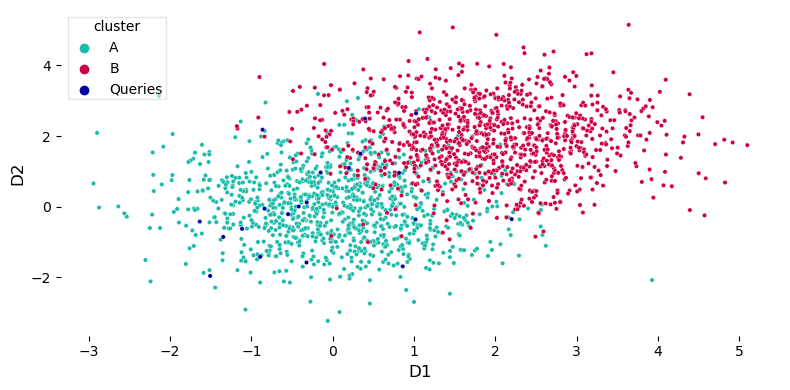

In [10]:
# render as static images inline with the code output
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.tick_params(labelsize=10)
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
sns.scatterplot(
    data=plot_df,
    x="D1",
    y="D2",
    hue="cluster",
    palette=[green, pink, blue],
    s=10,
    ax=ax,
)
ax.legend(
    title="cluster", loc="upper left", borderpad=0.2, fancybox=False, framealpha=0.5
)
plt.tight_layout()
plt.box(on=None)
plt.show()

## Building a classifier using Pinecone 

We will use euclidean distance to measure similarity in this example. 

In [13]:
index_name = "simple-knn-classifier"

create_index(index_name)
index = pc.Index(index_name)

In [15]:
items_df = pd.DataFrame()
items_df["id"] = [f"A-{ii}" for ii in range(len(A_vectors))] + [
    f"B-{ii}" for ii in range(len(B_vectors))
]
items_df["vector"] = [*A_vectors.tolist(), *B_vectors.tolist()]
items_df.sample(5)

,id,vector
271,A-271,"[0.19655477651157463, 1.0318445394686349, -1.4..."
836,A-836,"[-1.3510743662080213, -1.3224579567435701, 0.4..."
1588,B-588,"[1.0055714782002076, 2.249548189598077, 0.8169..."
391,A-391,"[-0.06259312789952241, -0.7539645888666763, -0..."
1991,B-991,"[-0.15373057379146138, 2.446981717009852, 1.36..."


In [19]:
items_df.shape

(2000, 2)

In [17]:
def chunks(iterable, batch_size = 100):
    it = iter(iterable)
    # break it into a chunk w batch size sample
    chunk = tuple(itertools.islice(it, batch_size))
    # repeat the process until chunk disappears
    while chunk:
        # suspend the function and return the value then continue
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))
        

# get the row iterations and create chunks inserted into the index
for vectors in chunks(((row.id, row.vector) for _, row in items_df.iterrows())):
    index.upsert(vectors = vectors)

In [18]:
# index indo
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.02,
 'namespaces': {'': {'vector_count': 2000}},
 'total_vector_count': 2000}

In [37]:
for query_vec in A_queries.tolist():
    results = index.query(vector = query_vec, top_k = 10)
    cc = Counter(match.id.split("-")[0] for match in results.matches)
    print(f" 'Count nearest neighbours' class labels: A = {cc['A']} B = {cc['B']}")

 'Count nearest neighbours' class labels: A = 10 B = 0
 'Count nearest neighbours' class labels: A = 10 B = 0
 'Count nearest neighbours' class labels: A = 10 B = 0
 'Count nearest neighbours' class labels: A = 10 B = 0
 'Count nearest neighbours' class labels: A = 0 B = 10
 'Count nearest neighbours' class labels: A = 10 B = 0
 'Count nearest neighbours' class labels: A = 6 B = 4
 'Count nearest neighbours' class labels: A = 8 B = 2
 'Count nearest neighbours' class labels: A = 10 B = 0
 'Count nearest neighbours' class labels: A = 10 B = 0
 'Count nearest neighbours' class labels: A = 10 B = 0
 'Count nearest neighbours' class labels: A = 10 B = 0
 'Count nearest neighbours' class labels: A = 10 B = 0
 'Count nearest neighbours' class labels: A = 1 B = 9
 'Count nearest neighbours' class labels: A = 9 B = 1
 'Count nearest neighbours' class labels: A = 10 B = 0
 'Count nearest neighbours' class labels: A = 10 B = 0
 'Count nearest neighbours' class labels: A = 8 B = 2
 'Count nearest

We can classify each of the query based on the mode of the points above for a `simple-knn` classification

In [38]:
pc.delete_index(index_name)